In [18]:
# model_selection_integration.py
from tpot import TPOTClassifier
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
# import mlflow
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
df = pd.read_csv('bank_churn_data.csv')

In [11]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,9815,1924,274,0,1,16,3,0,1,1,0,52408,0
1,1,16380,1925,233,0,1,16,1,0,1,1,1,5312,0
2,2,12091,1178,284,0,1,24,10,0,1,1,0,53528,0
3,3,15700,1299,187,0,1,17,2,26366,0,1,1,15979,0
4,4,18146,467,322,2,1,16,5,0,1,1,1,1630,0


## Pre processing

In [ ]:
# Encode categorical variables
label_encoder = LabelEncoder()
for i_col in df.columns:
    df[i_col] = label_encoder.fit_transform(df[i_col])

In [13]:
df.shape

(165034, 14)

In [12]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [14]:
df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [15]:
df['Exited'].unique()

array([0, 1], dtype=int64)

In [16]:
df.describe()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,11483.789019,1547.281948,262.465977,0.648545,0.564429,21.386151,5.020353,6820.122969,0.554455,0.753954,0.497770,27258.516603,0.211599
std,47641.3565,6623.113800,772.771233,80.063204,0.816574,0.495833,9.533895,2.806159,9495.748331,0.547154,0.430707,0.499997,16567.801582,0.408443
min,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41258.2500,5834.000000,924.000000,203.000000,0.000000,0.000000,14.000000,3.000000,0.000000,0.000000,1.000000,0.000000,12742.000000,0.000000
50%,82516.5000,11505.000000,1589.000000,265.000000,0.000000,1.000000,21.000000,5.000000,0.000000,1.000000,1.000000,0.000000,26775.000000,0.000000
75%,123774.7500,17191.000000,2186.000000,316.000000,1.000000,1.000000,26.000000,7.000000,13366.750000,1.000000,1.000000,1.000000,41931.750000,0.000000
max,165033.0000,23220.000000,2796.000000,456.000000,2.000000,1.000000,70.000000,10.000000,30074.000000,3.000000,1.000000,1.000000,55297.000000,1.000000


## Basic EDA

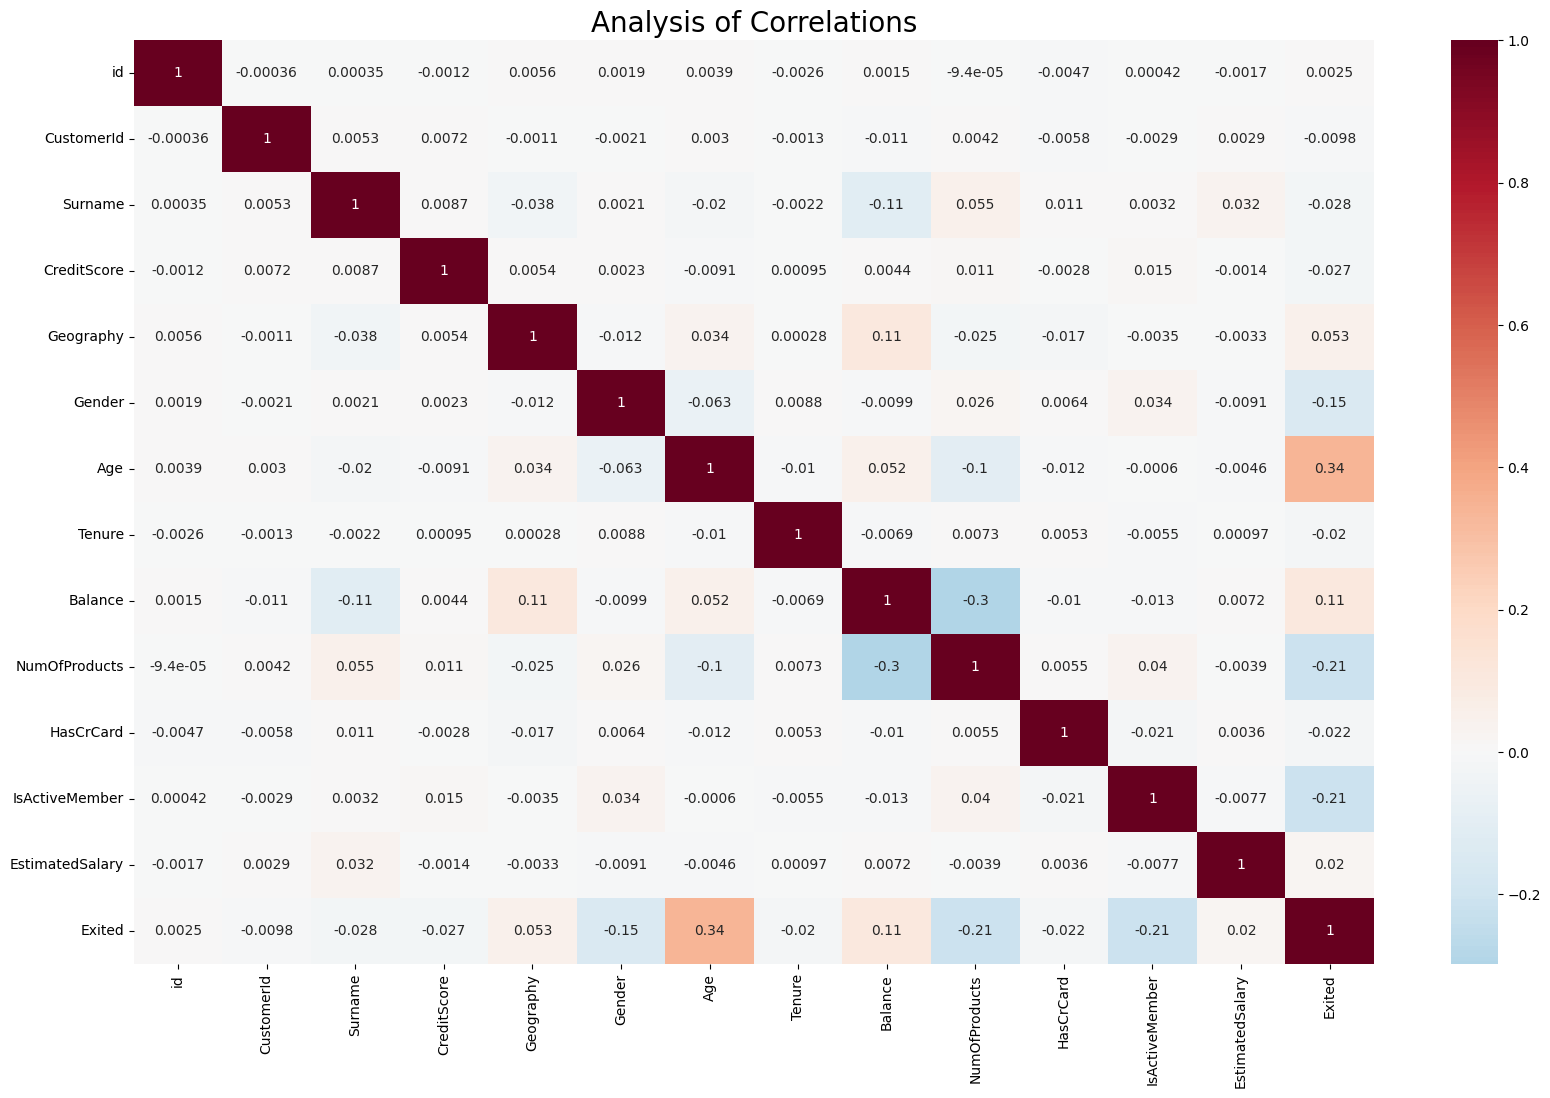

In [19]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="RdBu_r", center=0)
plt.title('Analysis of Correlations', size=20)
plt.show()

### Key Observations:
Age and Exited: There is a moderate positive correlation (0.34). This suggests that older customers may be more likely to exit.

Balance and Exited: A positive correlation (0.11) indicates that higher balances are somewhat associated with exiting.

NumOfProducts and Exited: A negative correlation (-0.22) suggests that more products are associated with a lower likelihood of exiting.

Gender and Exited: A slight negative correlation (-0.15) suggests gender has a weak inverse relationship with exiting.



In [22]:
y_col = 'Exited'
# Split features and target
y = df[y_col]
X = df.drop(['id', 'CustomerId', 'Surname', y_col], axis=1)

In [23]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (132027, 10)
Shape of X_test:  (33007, 10)
Shape of y_train:  (132027,)
Shape of y_test (33007,)


In [24]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Convert to pandas DataFrame for TPOT
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

## Model Selection

In [9]:
from tpot import TPOTClassifier

# Initialize TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, cv=5, scoring='roc_auc',
                      verbosity=2, random_state=42, config_dict='TPOT light')

# Fit the TPOTClassifier to the training data
tpot.fit(X_train, y_train)

# Evaluate the trained TPOT pipeline on the validation set
tpot_accuracy = tpot.score(X_test, y_test)
print(f"TPOT accuracy on validation set: {tpot_accuracy}")

# Export the best pipeline
tpot.export('tpot_exported_pipeline.py')

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8815381035061162

Generation 2 - Current best internal CV score: 0.8817293638132426

Generation 3 - Current best internal CV score: 0.8819113611269138

Generation 4 - Current best internal CV score: 0.8822385862116169

Generation 5 - Current best internal CV score: 0.8822385862116169

Best pipeline: DecisionTreeClassifier(MinMaxScaler(RobustScaler(SelectPercentile(input_matrix, percentile=85))), criterion=gini, max_depth=8, min_samples_leaf=14, min_samples_split=17)
TPOT accuracy on validation set: 0.8844236925695146
